# Подключаем гугл диск

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Распаковка данных

In [3]:
!unzip -n "/content/gdrive/MyDrive/agrocode/folder.zip" -d "/content/gdrive/MyDrive/agrocode/data_row"

Archive:  /content/gdrive/MyDrive/agrocode/folder.zip
warning [/content/gdrive/MyDrive/agrocode/folder.zip]:  1389570114 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/gdrive/MyDrive/agrocode/folder.zip]:  start of central directory not found;
  zipfile corrupt.
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
# ! cp -a '/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/train_1/circle/.' '/content/gdrive/MyDrive/ups_2022_circle/data/train/circle/' 

# Подгружаем зависимости

In [ ]:
! pip3 install torch torchvision torchaudio

# На CUDA будет побыстрее

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# !pip install Pillow==5.3.0
# import PIL
# print(PIL.PILLOW_VERSION)

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Nov 20 11:44:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

# Удобно подавать данные, обёрнутые в датасет, приведенные к одному формату - тензору

In [ ]:
class StrawberryDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        transform_wb = transforms.ToTensor()
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        try: 
          x = transform(x)
        except:
          x = transform_wb(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
TRAIN_DIR_1 = Path('/content/gdrive/MyDrive/agrocode/data_3')
# TEST_DIR_1 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/valid_1')

# TRAIN_DIR_2 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/train_2')
# TEST_DIR_2 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/valid_2')

# TRAIN_DIR_3 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/train_3')
# TEST_DIR_3 = Path('/content/gdrive/MyDrive/ups_2022_circle/data/ups_2022_circle/valid_3')

train_val_files = sorted(list(TRAIN_DIR_1.rglob('*.jpg')) + list(TRAIN_DIR_1.rglob('*.JPG'))) #+ list(TRAIN_DIR_2.rglob('*.png')) + list(TRAIN_DIR_3.rglob('*.png')))
# test_files = sorted(list(TEST_DIR_1.rglob('*.jpg'))) #+ list(TEST_DIR_2.rglob('*.png')) + list(TEST_DIR_3.rglob('*.png')))

In [ ]:
len(train_val_files)

1565

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = StrawberryDataset(val_files, mode='val')

In [ ]:
len(val_dataset)

313

# Попробуем простую архитектурку

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    max_acc = 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) 
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc> max_acc:
              max_acc = val_acc
              torch.save(model.state_dict(), '/content/gdrive/MyDrive/agrocode/weights/densenet_{}'.format(round(100 * float(max_acc))))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
if val_dataset is None:
    val_dataset = StrawberryDataset(val_files, mode='val')
    
train_dataset = StrawberryDataset(train_files, mode='train')

In [ ]:
densenet_frozed,_=initialize_model("densenet", 2, feature_extract=True, use_pretrained=True)
densenet_frozed.cuda()
history = train(train_dataset, val_dataset, model=densenet_frozed, epochs=40, batch_size=64)
torch.save(densenet_frozed.state_dict(), "gdrive/My Drive/agrocode/densenet_frozed_final.pth") 

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 0.615969011387505


epoch:   2%|▎         | 1/40 [00:06<04:19,  6.65s/it]


Epoch 001 train_loss: 0.6160     val_loss 0.4404 train_acc 0.7045 val_acc 0.8403
loss 0.35670842339817327


epoch:   5%|▌         | 2/40 [00:13<04:14,  6.69s/it]


Epoch 002 train_loss: 0.3567     val_loss 0.2924 train_acc 0.8522 val_acc 0.9010
loss 0.2595267646228924


epoch:   8%|▊         | 3/40 [00:20<04:08,  6.73s/it]


Epoch 003 train_loss: 0.2595     val_loss 0.2369 train_acc 0.9169 val_acc 0.9233
loss 0.21232331789339692


epoch:  10%|█         | 4/40 [00:27<04:08,  6.91s/it]


Epoch 004 train_loss: 0.2123     val_loss 0.2052 train_acc 0.9401 val_acc 0.9265
loss 0.18536260890694092


epoch:  12%|█▎        | 5/40 [00:33<03:57,  6.80s/it]


Epoch 005 train_loss: 0.1854     val_loss 0.1895 train_acc 0.9569 val_acc 0.9201
loss 0.16711722328640022


epoch:  15%|█▌        | 6/40 [00:40<03:51,  6.81s/it]


Epoch 006 train_loss: 0.1671     val_loss 0.1753 train_acc 0.9601 val_acc 0.9329
loss 0.15381822637475717


epoch:  18%|█▊        | 7/40 [00:47<03:42,  6.74s/it]


Epoch 007 train_loss: 0.1538     val_loss 0.1658 train_acc 0.9641 val_acc 0.9393
loss 0.14330334599597006


epoch:  20%|██        | 8/40 [00:54<03:35,  6.74s/it]


Epoch 008 train_loss: 0.1433     val_loss 0.1592 train_acc 0.9665 val_acc 0.9393
loss 0.13517479408092012


epoch:  22%|██▎       | 9/40 [01:00<03:29,  6.75s/it]


Epoch 009 train_loss: 0.1352     val_loss 0.1539 train_acc 0.9712 val_acc 0.9489
loss 0.12834316644424829


epoch:  25%|██▌       | 10/40 [01:07<03:20,  6.68s/it]


Epoch 010 train_loss: 0.1283     val_loss 0.1491 train_acc 0.9760 val_acc 0.9425
loss 0.12233229505177885


epoch:  28%|██▊       | 11/40 [01:13<03:13,  6.66s/it]


Epoch 011 train_loss: 0.1223     val_loss 0.1459 train_acc 0.9768 val_acc 0.9457
loss 0.11797020991389363


epoch:  30%|███       | 12/40 [01:20<03:04,  6.59s/it]


Epoch 012 train_loss: 0.1180     val_loss 0.1429 train_acc 0.9776 val_acc 0.9489
loss 0.1141593349151337


epoch:  32%|███▎      | 13/40 [01:26<02:56,  6.52s/it]


Epoch 013 train_loss: 0.1142     val_loss 0.1399 train_acc 0.9784 val_acc 0.9489
loss 0.11046631024858822


epoch:  35%|███▌      | 14/40 [01:33<02:50,  6.55s/it]


Epoch 014 train_loss: 0.1105     val_loss 0.1382 train_acc 0.9824 val_acc 0.9489
loss 0.10771692337129063


epoch:  38%|███▊      | 15/40 [01:40<02:46,  6.67s/it]


Epoch 015 train_loss: 0.1077     val_loss 0.1360 train_acc 0.9816 val_acc 0.9521
loss 0.10512886163049613


epoch:  40%|████      | 16/40 [01:46<02:38,  6.60s/it]


Epoch 016 train_loss: 0.1051     val_loss 0.1338 train_acc 0.9848 val_acc 0.9521
loss 0.10286384497206813


epoch:  42%|████▎     | 17/40 [01:53<02:31,  6.57s/it]


Epoch 017 train_loss: 0.1029     val_loss 0.1329 train_acc 0.9872 val_acc 0.9521
loss 0.10095516632730588


epoch:  45%|████▌     | 18/40 [01:59<02:24,  6.59s/it]


Epoch 018 train_loss: 0.1010     val_loss 0.1316 train_acc 0.9888 val_acc 0.9521
loss 0.09914477671773289


epoch:  48%|████▊     | 19/40 [02:06<02:17,  6.56s/it]


Epoch 019 train_loss: 0.0991     val_loss 0.1304 train_acc 0.9888 val_acc 0.9521
loss 0.09761321147124226


epoch:  50%|█████     | 20/40 [02:12<02:10,  6.53s/it]


Epoch 020 train_loss: 0.0976     val_loss 0.1297 train_acc 0.9888 val_acc 0.9521
loss 0.09638737339657336


epoch:  52%|█████▎    | 21/40 [02:19<02:04,  6.53s/it]


Epoch 021 train_loss: 0.0964     val_loss 0.1287 train_acc 0.9888 val_acc 0.9521
loss 0.09505349356002701


epoch:  55%|█████▌    | 22/40 [02:26<01:58,  6.60s/it]


Epoch 022 train_loss: 0.0951     val_loss 0.1280 train_acc 0.9888 val_acc 0.9553
loss 0.09401777308112896


epoch:  57%|█████▊    | 23/40 [02:32<01:51,  6.56s/it]


Epoch 023 train_loss: 0.0940     val_loss 0.1274 train_acc 0.9888 val_acc 0.9553
loss 0.09300236465831915


epoch:  60%|██████    | 24/40 [02:39<01:45,  6.58s/it]


Epoch 024 train_loss: 0.0930     val_loss 0.1266 train_acc 0.9888 val_acc 0.9553
loss 0.09213359594440308


epoch:  62%|██████▎   | 25/40 [02:45<01:38,  6.57s/it]


Epoch 025 train_loss: 0.0921     val_loss 0.1261 train_acc 0.9888 val_acc 0.9553
loss 0.09136556160335724


epoch:  65%|██████▌   | 26/40 [02:52<01:31,  6.52s/it]


Epoch 026 train_loss: 0.0914     val_loss 0.1255 train_acc 0.9888 val_acc 0.9553
loss 0.09066779998401864


epoch:  68%|██████▊   | 27/40 [02:58<01:24,  6.51s/it]


Epoch 027 train_loss: 0.0907     val_loss 0.1251 train_acc 0.9896 val_acc 0.9553
loss 0.09005741708385297


epoch:  70%|███████   | 28/40 [03:05<01:17,  6.47s/it]


Epoch 028 train_loss: 0.0901     val_loss 0.1247 train_acc 0.9896 val_acc 0.9553
loss 0.08954189260737203


epoch:  72%|███████▎  | 29/40 [03:11<01:11,  6.49s/it]


Epoch 029 train_loss: 0.0895     val_loss 0.1244 train_acc 0.9896 val_acc 0.9553
loss 0.08897969950311863


epoch:  75%|███████▌  | 30/40 [03:18<01:04,  6.49s/it]


Epoch 030 train_loss: 0.0890     val_loss 0.1241 train_acc 0.9896 val_acc 0.9553
loss 0.08855291746390133


epoch:  78%|███████▊  | 31/40 [03:24<00:58,  6.53s/it]


Epoch 031 train_loss: 0.0886     val_loss 0.1237 train_acc 0.9896 val_acc 0.9553
loss 0.08809048539628617


epoch:  80%|████████  | 32/40 [03:31<00:51,  6.49s/it]


Epoch 032 train_loss: 0.0881     val_loss 0.1234 train_acc 0.9896 val_acc 0.9553
loss 0.08770538438052035


epoch:  82%|████████▎ | 33/40 [03:37<00:45,  6.49s/it]


Epoch 033 train_loss: 0.0877     val_loss 0.1232 train_acc 0.9896 val_acc 0.9553
loss 0.0873735001007208


epoch:  85%|████████▌ | 34/40 [03:44<00:39,  6.54s/it]


Epoch 034 train_loss: 0.0874     val_loss 0.1230 train_acc 0.9896 val_acc 0.9553
loss 0.08707098272471382


epoch:  88%|████████▊ | 35/40 [03:50<00:32,  6.52s/it]


Epoch 035 train_loss: 0.0871     val_loss 0.1228 train_acc 0.9896 val_acc 0.9553
loss 0.08679666934302821


epoch:  90%|█████████ | 36/40 [03:57<00:26,  6.54s/it]


Epoch 036 train_loss: 0.0868     val_loss 0.1226 train_acc 0.9896 val_acc 0.9585
loss 0.0865399632305383


epoch:  92%|█████████▎| 37/40 [04:03<00:19,  6.55s/it]


Epoch 037 train_loss: 0.0865     val_loss 0.1225 train_acc 0.9896 val_acc 0.9585
loss 0.08633452599136213


epoch:  95%|█████████▌| 38/40 [04:10<00:13,  6.53s/it]


Epoch 038 train_loss: 0.0863     val_loss 0.1224 train_acc 0.9896 val_acc 0.9585
loss 0.08610824983531294


epoch:  98%|█████████▊| 39/40 [04:17<00:06,  6.56s/it]


Epoch 039 train_loss: 0.0861     val_loss 0.1222 train_acc 0.9896 val_acc 0.9585
loss 0.08593095179659109


epoch: 100%|██████████| 40/40 [04:23<00:00,  6.59s/it]


Epoch 040 train_loss: 0.0859     val_loss 0.1221 train_acc 0.9896 val_acc 0.9585


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

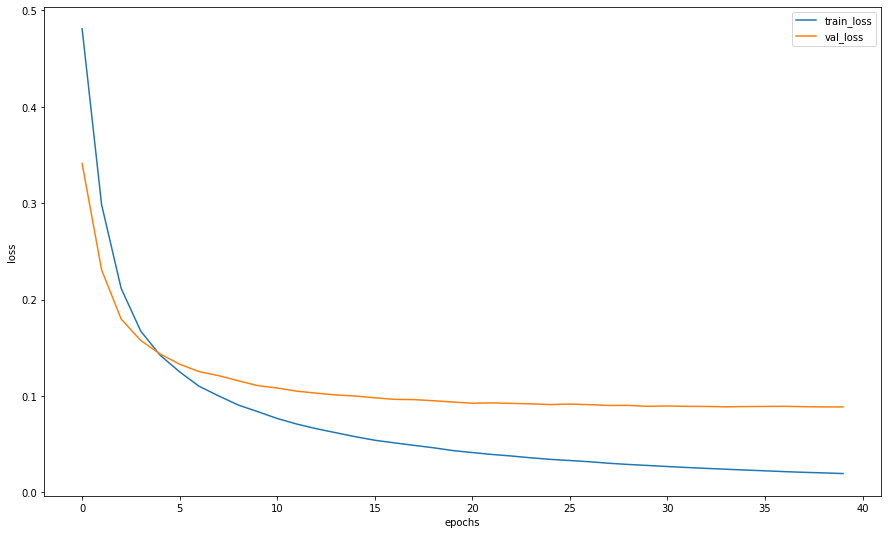

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Scheduler!!!



In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    max_acc = 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) 
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc> max_acc:
              max_acc = val_acc
              torch.save(model.state_dict(), '/content/gdrive/MyDrive/agrocode/weights/densenet_{}'.format(round(100 * float(max_acc))))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
densenet_frozed,_=initialize_model("densenet", 2, feature_extract=True, use_pretrained=True)
densenet_frozed.cuda()
history = train(train_dataset, val_dataset, model=densenet_frozed, epochs=4, batch_size=64)
torch.save(densenet_frozed.state_dict(), "gdrive/My Drive/agrocode/densenet_frozed_final.pth") 

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.38625545242723947


epoch:  25%|██▌       | 1/4 [00:10<00:30, 10.32s/it]


Epoch 001 train_loss: 0.3863     val_loss 0.1696 train_acc 0.8506 val_acc 0.9968
loss 0.10963886102643637


epoch:  50%|█████     | 2/4 [00:20<00:20, 10.13s/it]


Epoch 002 train_loss: 0.1096     val_loss 0.0734 train_acc 0.9968 val_acc 1.0000
loss 0.0540127878467115


epoch:  75%|███████▌  | 3/4 [00:30<00:10, 10.00s/it]


Epoch 003 train_loss: 0.0540     val_loss 0.0465 train_acc 1.0000 val_acc 1.0000
loss 0.035808712249984755


epoch: 100%|██████████| 4/4 [00:40<00:00, 10.04s/it]



Epoch 004 train_loss: 0.0358     val_loss 0.0352 train_acc 1.0000 val_acc 1.0000


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()